In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import csv
import json
from typing import Union

In [33]:
# helper functions
output_format = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'clubs', 'spades', 'diamonds', 'hearts', 'joker']
suits = ['clubs', 'diamonds', 'hearts', 'spades']
def parse_output(output: np.array) -> str:
    """
    Parse the output from a list of numbers into a string like 'joker' or 'ace of hearts' or 'eight of spades'
    :param output: the output from the DL model as a list of 18 numbers between 0 and 1
    :return: string name of the card
    """
    if output.shape != np.array(output_format).shape:
        raise ValueError('output is not of the correct shape')
    if max(output) == output[-1]:
        return 'joker'
    outputs = list(output)
    rank_index = outputs[:13].index(max(output[:13]))
    suit_index = outputs[13:17].index(max(output[13:17])) + 13
    return f"{output_format[rank_index]} of {output_format[suit_index]}"    

In [28]:
# import and assemble data
train_inputs = []
train_outputs = []
validation_inputs = []
validation_outputs = []
test_inputs = []
test_outputs = []



with open('data/cards.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')

    flag = True
    for row in csv_reader:
        print(row)
        if flag:
            headers = row
            flag = False
        else:
            # determine input
            img = np.asarray(Image.open('data/'+row[1]))
            
            # determine output
            name = row[2]
            output = [1 if title in name else 0 for title in output_format]
                
            if sum(output) == 2 and row[2] != 'joker': # suit and number activated
                output = np.array(output)
            elif sum(output) == 1 and row[2] == 'joker': # just joker activated
                output = np.array(output)
            else:
                print(f"Something went wrong with {'data/'+row[1]}.")
                exit(1)
                
            # assembling data
            if 'train' == row[4]:
                train_inputs.append(img)
                train_outputs.append(output)
            elif 'test' == row[4]:
                test_inputs.append(img)
                test_outputs.append(output)
            elif 'valid' == row[4]:
                validation_inputs.append(img)
                validation_outputs.append(output)
            else:
                print(f"Something went wrong with {'data/'+row[1]} and category {row[4]}")
                exit(1)
                
print("Data importing complete")


['class index', 'filepaths', 'labels', 'card type', 'data set']
['0', 'train/ace of clubs/001.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/002.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/003.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/004.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/005.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/006.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/007.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/008.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/009.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/010.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/011.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/012.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/013.jpg', 'ace of clubs', 'ace', 'train']
['0', 'train/ace of clubs/014.jpg', 'ace of clubs', 

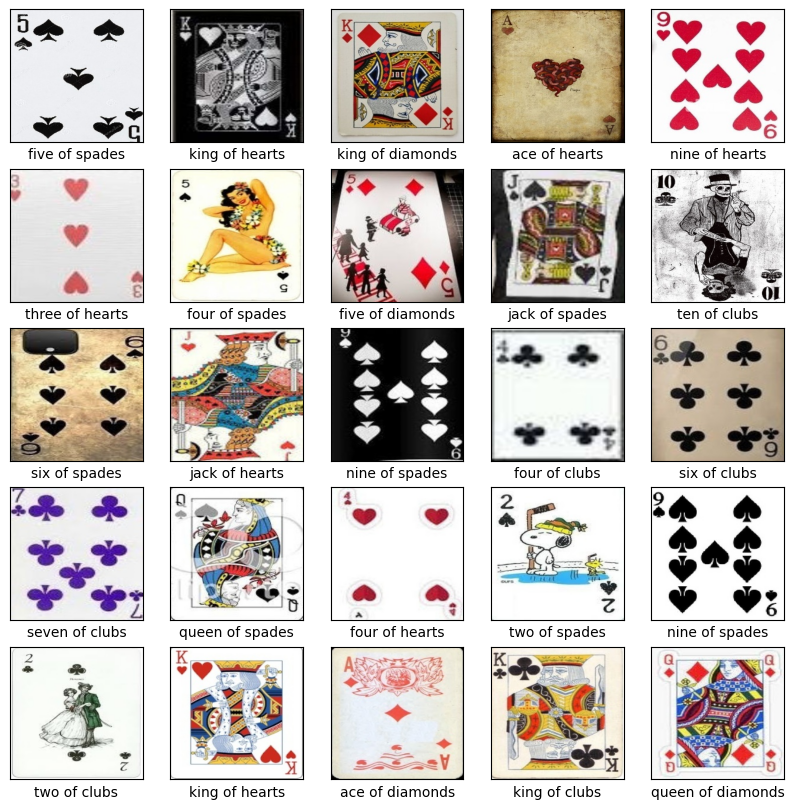

In [34]:
# check random samples
import random

samples = []
index = random.randint(0, len(train_inputs)-1)
while len(samples) < 25:
    if index not in samples:
        samples.append(index)
    index = random.randint(0, len(train_inputs)-1)

plt.figure(figsize=[10,10])
counter = 1

def one_indices(output):
    indices = []
    for i in range(len(output)):
        if output[i] == 1:
            indices.append(i)
    return indices

for index in samples:
    plt.subplot(5, 5, counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_inputs[index])
    plt.xlabel(parse_output(train_outputs[index]))
    counter += 1
    
plt.show()
        